/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Epoch [1/10], Loss: 1.0326
Epoch [2/10], Loss: 0.5786
Epoch [3/10], Loss: 0.4541
Epoch [4/10], Loss: 0.3214
Epoch [5/10], Loss: 0.2597
Epoch [6/10], Loss: 0.1956
Epoch [7/10], Loss: 0.1971
Epoch [8/10], Loss: 0.1703
Epoch [9/10], Loss: 0.1245
Epoch [10/10], Loss: 0.1208
Validation Accuracy: 0.8368
                   precision    recall  f1-score   support

        abandoned       0.91      0.91      0.91        22
       commercial       0.72      0.71      0.71       126
       industrial       0.95      0.60      0.73        30
           others       0.90      0.89      0.89       225
        religious       0.94      0.76      0.84        21
      residential       0.81      0.86      0.84       248
underconstruction       0.84      0.97      0.90        39

         accuracy                           0.84       711
        macro avg       0.87      0.81      0.83       711
     weighted avg       0.84      0.84      0.84       711



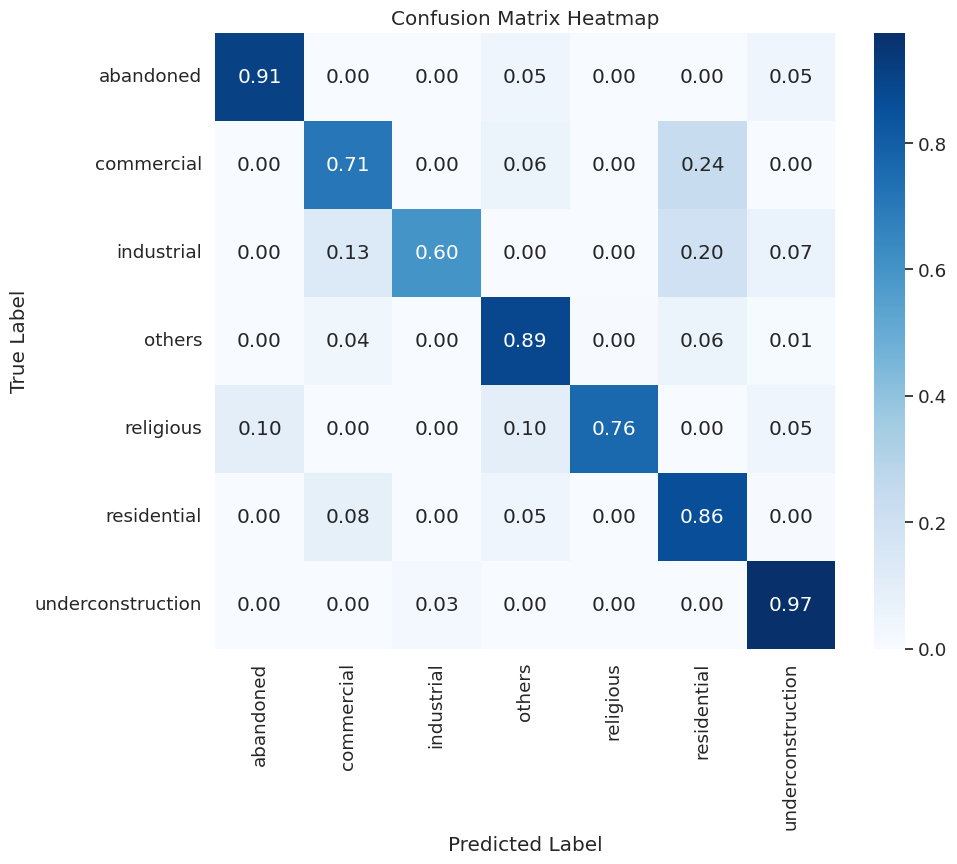

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from timm.models import resnet50
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root='/content/drive/MyDrive/AI/pure', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

model = resnet50(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

torch.save(model.state_dict(), 'resnet_model.pth')

model.eval()
predictions = []
targets = []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

correct = sum(p == t for p, t in zip(predictions, targets))
total = len(targets)
accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.4f}')

print(classification_report(targets, predictions, target_names=dataset.classes))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(targets, predictions)

cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()
